In [1]:
import random
from colorutils import Color
from configs import CFG1
from generators import create_image

In [2]:
import pandas as pd

messages = pd.read_csv("texts/message_samples.csv")
options = pd.read_csv("texts/option_samples.csv")
names = pd.read_csv("texts/name_samples.csv")
messages.shape, options.shape, names.shape

((14, 5), (16, 3), (9, 2))

'<ruby>天真<rt>てんしん</rt></ruby>らんまんを装っておられるところを見ると、そのつもりはないようではありますが'

'<ruby>妹尾 康平<rt>せのお こうへい</rt></ruby>'

'それに、この<ruby>村<rt>むら</rt></ruby>では<ruby>人手<rt>ひとで</rt></ruby>が多い<ruby>方<rt>ほう</rt></ruby>が<ruby>都合<rt>つごう</rt></ruby>が良いはずだ。'

'トライアルダンジョン、か。'

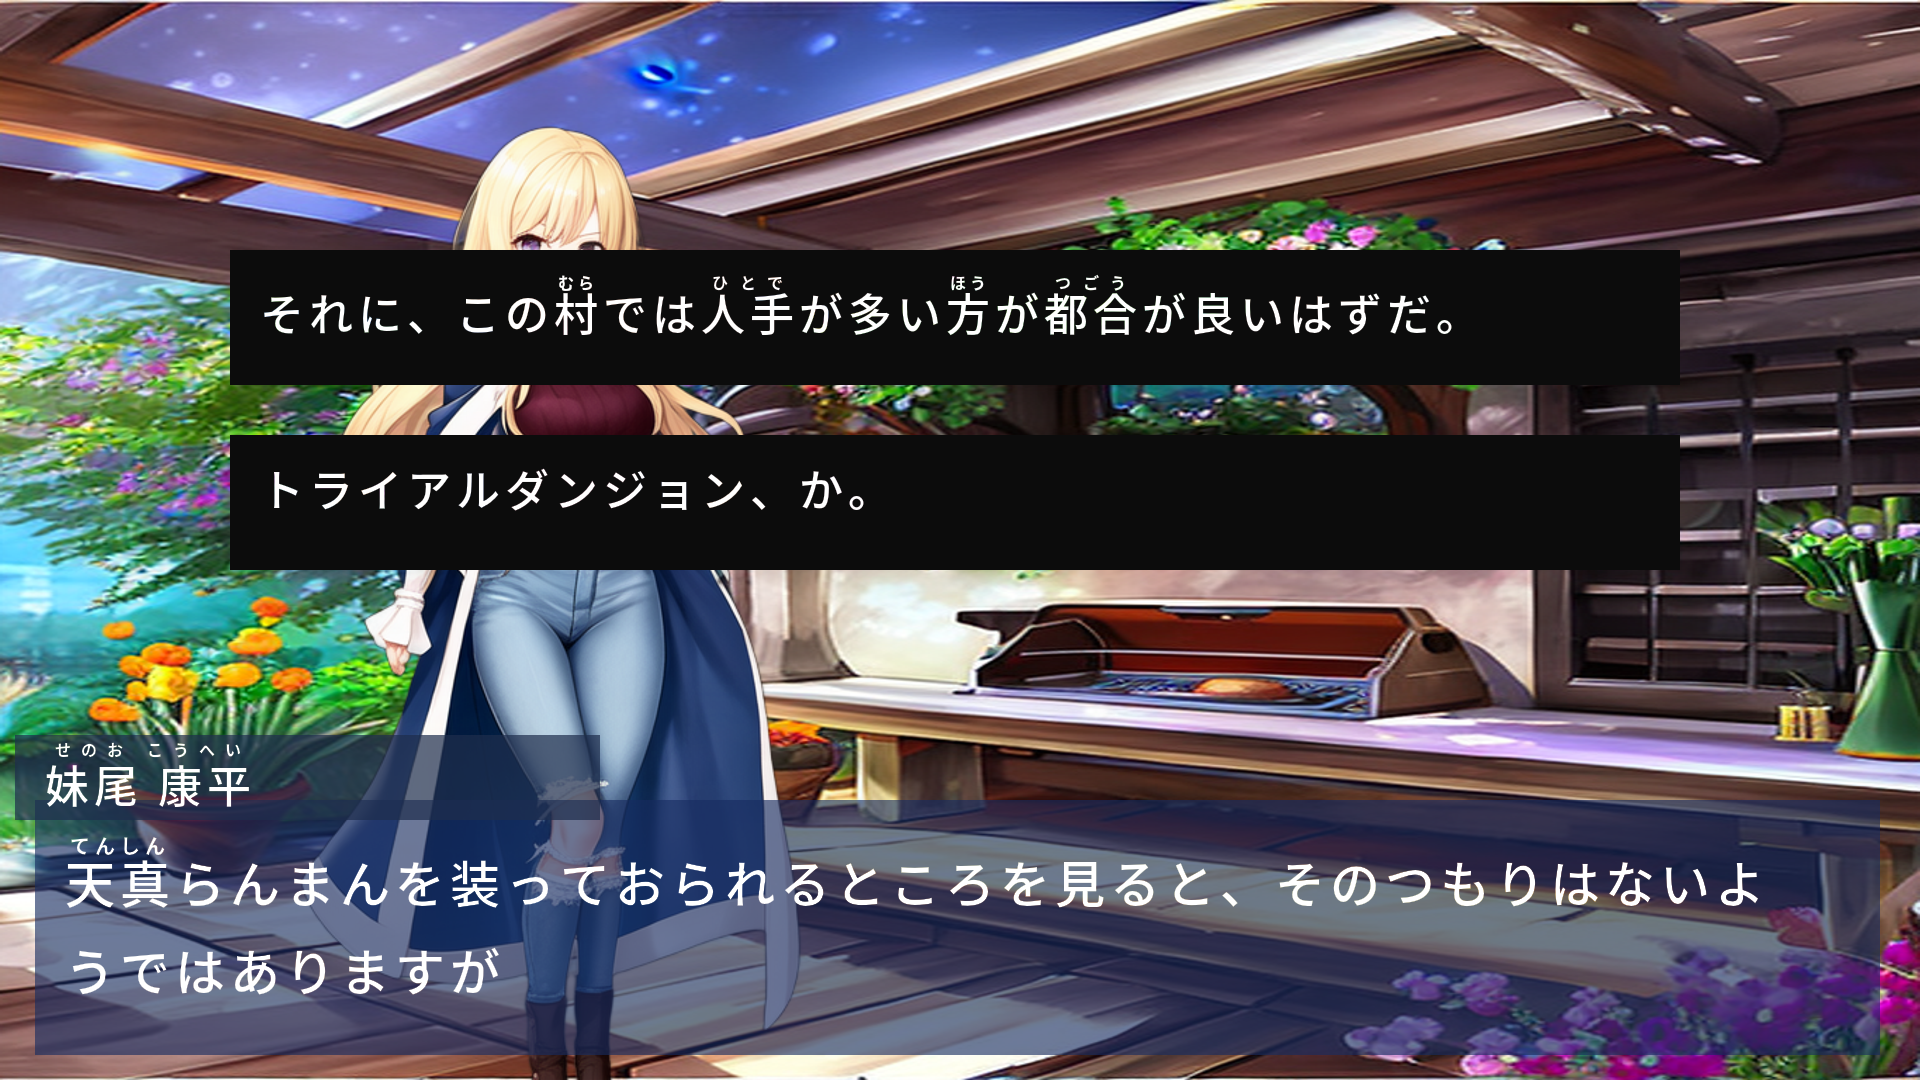

In [3]:
text = messages.sample(1)["text_ruby_hiragana"].values[0]
option_text = options.sample(1)["text_ruby_hiragana"].values[0]
option2_text = options.sample(1)["text_ruby_hiragana"].values[0]

name_text, name_ruby = names.sample(1)[["name", "ruby"]].values[0]
if type(name_ruby) == str:
    name_text = f"<ruby>{name_text}<rt>{name_ruby}</rt></ruby>"
display(text, name_text, option_text, option2_text)

cfg = CFG1()
output = create_image(cfg, text, name_text, [option_text, option2_text])
display(output.image)

In [4]:
output.text, output.name_text, output.option_texts

('<ruby>天真<rt>てんしん</rt></ruby>らんまんを装っておられるところを見ると、そのつもりはないようではありますが',
 '<ruby>妹尾 康平<rt>せのお こうへい</rt></ruby>',
 ['それに、この<ruby>村<rt>むら</rt></ruby>では<ruby>人手<rt>ひとで</rt></ruby>が多い<ruby>方<rt>ほう</rt></ruby>が<ruby>都合<rt>つごう</rt></ruby>が良いはずだ。',
  'トライアルダンジョン、か。'])

In [ ]:
output.img.save("./outputs/image.png")